In [1]:
from PIL import Image

img_path = 'D:/ConcordiaU/Winter 23/AI/Project/Datasets/2. UTKFace/FinalDataset/train/23To28/23_0_0_20170111181750321.jpg.chip.jpg'
img = Image.open(img_path)
img.size

(200, 200)

### Imports

In [2]:
import os
import numpy as np
from PIL import Image, ImageFilter
import cv2
import torch,torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt 
%matplotlib inline

### Paths

In [3]:
##Paths
train_dir = 'D:/ConcordiaU/Winter 23/AI/Project/Datasets/2. UTKFace/FinalDataset/train/'
test_dir = 'D:/ConcordiaU/Winter 23/AI/Project/Datasets/2. UTKFace/FinalDataset/test/'
val_dir = 'D:/ConcordiaU/Winter 23/AI/Project/Datasets/2. UTKFace/FinalDataset/val/'

### Transforms Normalizd(HorizontalFlip/Rotation/GuassianBlur/Mean/Std)

In [4]:
transforms = transforms.Compose([    
    transforms.Resize((224, 224)),    ##Original Size 200*200
    transforms.RandomHorizontalFlip(),
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomRotation(degrees=15),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),    
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #Imagenet pretrianed model specific to the normalization technique
    
])



## For Attempt 1 and 2.
# transforms = transforms.Compose([    
#     transforms.Resize((224, 224)),    ##Original Size 200*200
#     transforms.ToTensor(),    
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #Imagenet pretrianed model specific to the normalization technique
# ])

> Need to try with Data Aug

>Need to try Gaussian Blur and Laplacian filter Thres(100)

In [5]:
train_dataset = datasets.ImageFolder(train_dir, transform=transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=transforms)

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

In [7]:
torch.cuda.is_available()

True

### RESNET-18 Model

In [8]:
model = torchvision.models.resnet18(pretrained=False, num_classes=4)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

C:\Users\suppu\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\suppu\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Third Try - Includes Graphs(Train acc and Loss + ROC Curve) Added Early Stop and Data Augmentation
> 50epoch

Epoch 1/50, Train Loss: 1.1697, Train Accuracy: 46.18%, Validation Loss: 0.0159, Validation Accuracy: 53.67%
Epoch 2/50, Train Loss: 0.9579, Train Accuracy: 56.96%, Validation Loss: 0.0142, Validation Accuracy: 59.67%
Epoch 3/50, Train Loss: 0.8917, Train Accuracy: 59.86%, Validation Loss: 0.0137, Validation Accuracy: 60.60%
Epoch 4/50, Train Loss: 0.8306, Train Accuracy: 63.09%, Validation Loss: 0.0168, Validation Accuracy: 53.29%
Epoch 5/50, Train Loss: 0.8050, Train Accuracy: 63.98%, Validation Loss: 0.0123, Validation Accuracy: 65.50%
Epoch 6/50, Train Loss: 0.7654, Train Accuracy: 66.12%, Validation Loss: 0.0126, Validation Accuracy: 64.65%
Epoch 7/50, Train Loss: 0.7520, Train Accuracy: 66.57%, Validation Loss: 0.0125, Validation Accuracy: 64.23%
Epoch 8/50, Train Loss: 0.7274, Train Accuracy: 67.47%, Validation Loss: 0.0154, Validation Accuracy: 57.90%
Epoch 9/50, Train Loss: 0.7125, Train Accuracy: 68.31%, Validation Loss: 0.0118, Validation Accuracy: 66.85%
Epoch 10/50, Train 

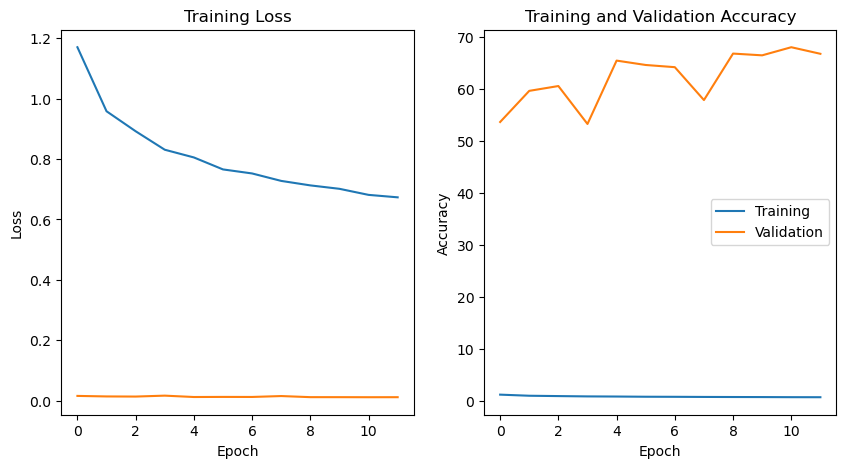

In [9]:
num_epochs = 50
train_losses = []
train_accs = []
val_accs = []
val_losses = []


patience = 7 
delta = 0.001 
best_val_loss = float('inf')
best_model_state_dict = None
counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        val_loss = 0.0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        
        val_loss /= len(val_loader.dataset) #Val loss and acc for each epoch
        val_acc = 100 * correct / total
        
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')

        if val_loss < best_val_loss - delta: # validation loss improvement
            best_val_loss = val_loss
            best_model_state_dict = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Validation loss hasn't improved for {} epochs. Stopping early.".format(patience))
                break


model.load_state_dict(best_model_state_dict) #Load the best model to eval on test
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

# Plot training accuracy and loss
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_losses,label='Training')
plt.plot(val_losses, label='Validation')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(train_losses, label='Training')
plt.plot(val_accs, label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
# Evaluation on test set and ROC curve
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # For ROC curve
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(outputs.cpu().numpy())  # Predicted probabilities for all classes

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
# Save the model
torch.save(model.state_dict(), 'face_age_detection_resnet18_Third_Try.pth')

Test Accuracy: 66.99%


In [11]:
from sklearn.metrics import roc_curve, auc

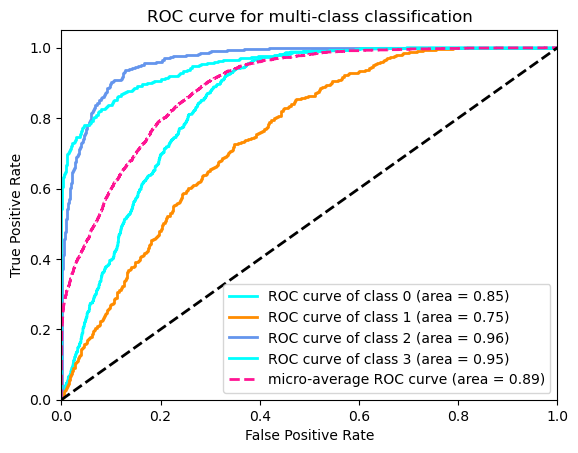

In [12]:
num_classes = 4
# Convert labels to one-hot encoding
y_true_onehot = label_binarize(y_true, classes=np.arange(num_classes))

# Convert y_pred list to numpy array
y_pred = np.array(y_pred)

# Calculate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_onehot.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class and micro-average
plt.figure()
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=lw, linestyle='--',
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for multi-class classification')
plt.legend(loc="lower right")
plt.show()


### Second Try - Includes Graphs(Train acc and Loss + ROC Curve)  
> Fail -Over fitting.
> also forgot the val loss line :)
>>30Epoch Only!!!!!!!!!
>>Saving model.

`num_epochs = 30
train_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        
        val_loss /= len(val_loader.dataset) #Val loss and acc for each epoch
        val_acc = 100 * correct / total

        val_accs.append(val_acc)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%')

# Plot training accuracy and loss
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(train_accs)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()
`



###### Output
<!-- # # -----------------------
Epoch 1/30, Train Loss: 1.1304, Train Accuracy: 49.18%, Validation Accuracy: 53.84%
Epoch 2/30, Train Loss: 0.9259, Train Accuracy: 58.66%, Validation Accuracy: 59.71%
Epoch 3/30, Train Loss: 0.8451, Train Accuracy: 62.45%, Validation Accuracy: 43.79%
Epoch 4/30, Train Loss: 0.7795, Train Accuracy: 65.59%, Validation Accuracy: 58.11%
Epoch 5/30, Train Loss: 0.7322, Train Accuracy: 67.85%, Validation Accuracy: 64.95%
Epoch 6/30, Train Loss: 0.6818, Train Accuracy: 69.53%, Validation Accuracy: 67.10%
Epoch 7/30, Train Loss: 0.6331, Train Accuracy: 72.07%, Validation Accuracy: 63.13%
Epoch 8/30, Train Loss: 0.5764, Train Accuracy: 74.96%, Validation Accuracy: 65.75%
Epoch 9/30, Train Loss: 0.5182, Train Accuracy: 77.99%, Validation Accuracy: 65.67%
Epoch 10/30, Train Loss: 0.4507, Train Accuracy: 81.03%, Validation Accuracy: 64.61%
Epoch 11/30, Train Loss: 0.3646, Train Accuracy: 85.06%, Validation Accuracy: 66.39%
Epoch 12/30, Train Loss: 0.2870, Train Accuracy: 88.67%, Validation Accuracy: 66.39%
Epoch 13/30, Train Loss: 0.2235, Train Accuracy: 91.75%, Validation Accuracy: 66.26%
Epoch 14/30, Train Loss: 0.1767, Train Accuracy: 93.67%, Validation Accuracy: 65.75%
Epoch 15/30, Train Loss: 0.1343, Train Accuracy: 95.73%, Validation Accuracy: 67.31%
 -->


> Stopped Training as it is overfitting.!

In [ ]:
# Evaluation on test set and ROC curve
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # For ROC curve
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(outputs[:, 1].cpu().numpy())  # Probability of positive class

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Save the model
torch.save(model.state_dict(), 'face_age_detection_resnet18.pth')

### First Try  - Just 10 epochs and Transforms Normalizd(Mean/Std)

In [28]:
# num_epochs = 10

# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0
#     correct = 0
#     total = 0
    
#     for images, labels in train_loader:
#         images = images.to(device)
#         labels = labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         _, predicted = torch.max(outputs.data, 1) #Train acc
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
        
#         train_loss += loss.item() * labels.size(0) #loss

#     train_loss /= len(train_loader.dataset) #Train loss and acc for each epoch
#     train_accuracy = 100 * correct / total
    
#     # evaluate on validation set
#     model.eval()
#     with torch.no_grad():
#         correct = 0
#         total = 0
#         val_loss = 0
#         for images, labels in val_loader:
#             images = images.to(device)
#             labels = labels.to(device)

#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             val_loss += loss.item() * labels.size(0)
            
#             _, predicted = torch.max(outputs.data, 1) #validation accuracy
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#         val_loss /= len(val_loader.dataset) #Val loss and acc for each epoch
#         val_accuracy = 100 * correct / total
        
#     print(f'Epoch {epoch + 1}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

Epoch 1, Training Loss: 1.1079, Training Accuracy: 49.63%, Validation Loss: 0.9816, Validation Accuracy: 54.05%
Epoch 2, Training Loss: 0.9066, Training Accuracy: 59.66%, Validation Loss: 0.9381, Validation Accuracy: 56.93%
Epoch 3, Training Loss: 0.8149, Training Accuracy: 63.81%, Validation Loss: 0.9157, Validation Accuracy: 59.80%
Epoch 4, Training Loss: 0.7575, Training Accuracy: 66.44%, Validation Loss: 0.9113, Validation Accuracy: 58.91%
Epoch 5, Training Loss: 0.7069, Training Accuracy: 69.15%, Validation Loss: 1.1559, Validation Accuracy: 55.19%
Epoch 6, Training Loss: 0.6560, Training Accuracy: 71.23%, Validation Loss: 1.0346, Validation Accuracy: 57.22%
Epoch 7, Training Loss: 0.5984, Training Accuracy: 73.78%, Validation Loss: 0.8142, Validation Accuracy: 64.48%
Epoch 8, Training Loss: 0.5396, Training Accuracy: 76.87%, Validation Loss: 0.8305, Validation Accuracy: 66.77%
Epoch 9, Training Loss: 0.4718, Training Accuracy: 80.16%, Validation Loss: 0.8636, Validation Accuracy:

#### Output-1
 - Epoch 1, Training Loss: 1.1079, Training Accuracy: 49.63%, Validation Loss: 0.9816, Validation Accuracy: 54.05%
 - Epoch 2, Training Loss: 0.9066, Training Accuracy: 59.66%, Validation Loss: 0.9381, Validation Accuracy: 56.93%
 - Epoch 3, Training Loss: 0.8149, Training Accuracy: 63.81%, Validation Loss: 0.9157, Validation Accuracy: 59.80%
 - Epoch 4, Training Loss: 0.7575, Training Accuracy: 66.44%, Validation Loss: 0.9113, Validation Accuracy: 58.91%
 - Epoch 5, Training Loss: 0.7069, Training Accuracy: 69.15%, Validation Loss: 1.1559, Validation Accuracy: 55.19%
 - Epoch 6, Training Loss: 0.6560, Training Accuracy: 71.23%, Validation Loss: 1.0346, Validation Accuracy: 57.22%
 - Epoch 7, Training Loss: 0.5984, Training Accuracy: 73.78%, Validation Loss: 0.8142, Validation Accuracy: 64.48%
 - Epoch 8, Training Loss: 0.5396, Training Accuracy: 76.87%, Validation Loss: 0.8305, Validation Accuracy: 66.77%
 - Epoch 9, Training Loss: 0.4718, Training Accuracy: 80.16%, Validation Loss: 0.8636, Validation Accuracy: 64.32%
 - Epoch 10, Training Loss: 0.3927, Training Accuracy: 83.87%, Validation Loss: 1.1208, Validation Accuracy: 61.57%
 
 
 
 - Test Accuracy: 61.22%

In [29]:
# # Test the model on the test set
# model.eval()
# with torch.no_grad():
#     correct = 0
#     total = 0
#     for images, labels in test_loader:
#         images = images.to(device)
#         labels = labels.to(device)

#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     accuracy = 100 * correct / total
#     print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 61.22%
